In [17]:
from scipy import optimize as opt
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

# Task 2 - Actual Example

## Task 2.1

Let's start by loading our matrices as we did for the small example, being sure to enter the correct constants for number of beams, etc. for the actual_example specs:

In [18]:
# Given information
num_beams = 126
vertical_resolution = 60
horizontal_resolution = 80
num_pixels = vertical_resolution*horizontal_resolution
max_critical_dose = 2
min_tumor_dose = 10

path_actual = "task/actualexample/"
tumor_raw = np.loadtxt(path_actual+"tumor_raw.txt")
critical_raw = np.loadtxt(path_actual+"critical_raw.txt")
beam_raw = np.loadtxt(path_actual+"beam_raw.txt")

Let us take a look at our treatment area (pink denoting tumor area, cyan denoting critical area, and purple denoting non-critical area):

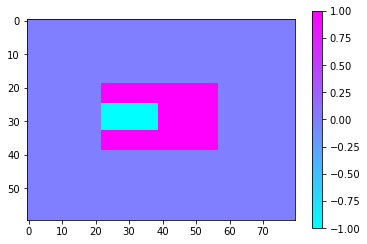

In [19]:
plt.imshow(tumor_raw-critical_raw, cmap='cool')
plt.colorbar()

And, dividing up our beam_raw into a proper set of beams:

In [20]:
beam_set = []
for i in range(0, num_beams):
    temp = beam_raw[i*vertical_resolution : i*vertical_resolution+vertical_resolution]
    beam_set.append(temp)

We can get a general sense of our set of beams by printing them out:

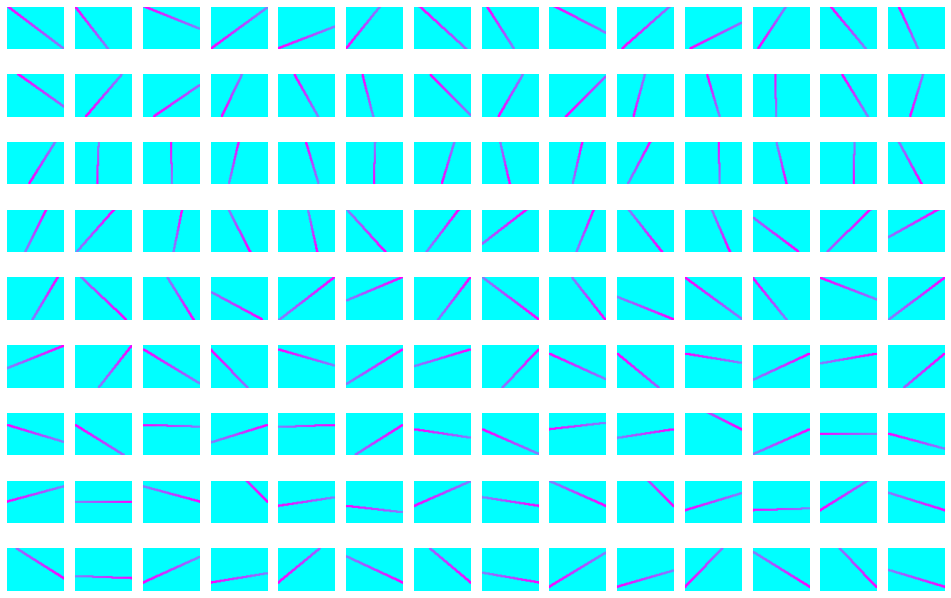

In [21]:
n_rows = 9
n_cols = 14
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(beam_set[index], cmap="cool")
        plt.axis('off')
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

Now, let's make a dosage matrix, where each row i corresponds to the amount of radiation received by a given pixel by the ith beam:

In [22]:
dosage_matrix = np.zeros((num_beams,num_pixels))
for i in range(0,num_beams):
    dosage_matrix[i] = beam_set[i].flatten()

In [23]:
dosage_matrix.shape

(126, 4800)

Now let's add our non-critical matrix. As with the small example, this will be the compliment of (tumor_raw+critical_raw).

In [24]:
non_critical_raw = 1-(tumor_raw+critical_raw)

For convenience, let us create flattened, vector versions of our various matrices:

In [25]:
tumor_flat = tumor_raw.flatten()
critical_flat = critical_raw.flatten()
non_critical_flat = non_critical_raw.flatten()
#print("Tumor locations:", tumor_flat,
#      "\nCritical locations:",critical_flat,
#     "\nNon-critical locations:",non_critical_flat)

Now we can go on to making the various components of our cost vector. Since to start, we want to minimize critical radiation and maximize tumor radiation, let’s make those two components of the cost vector first:

In [26]:
cost_tumor = dosage_matrix @ tumor_flat
cost_critical = dosage_matrix @ critical_flat
#cost_non_critical = dosage_matrix @ non_critical_flat

Now we can go ahead defining our objective function and constraints. But first, we need to make vectors representative of the right-hand sides of our constraints. For our minimum tumor dosage vector, this will be a vector of all zeros, except for 10 at entries corresponding to pixels with values of 1 in our (flattened) tumor_raw. For our maximum critical dosage vector, it will be essentially the same—the only difference being for implementation purposes, instead of values of zeros in areas that aren’t critical, we’ll use an arbitrarily large value. This way we can use the vector in a less than or equal constraint and not be mistakenly constrained to be less than or equal to zero where we don’t need to be.

In [27]:
min_tumor_dose_vector = min_tumor_dose * tumor_flat
max_critical_dose_vector = max_critical_dose * critical_flat
max_critical_dose_vector[max_critical_dose_vector==0] = 999

print("Tumor dosage constraint:",min_tumor_dose_vector,
      "\nCritical dosage constraint:",max_critical_dose_vector)

Tumor dosage constraint: [0. 0. 0. ... 0. 0. 0.] 
Critical dosage constraint: [999. 999. 999. ... 999. 999. 999.]


We want to ultimately produce a weight vector, with each entry corresponding to a weight on a given beam. So, let us make an initial weight vector of zeros:

In [28]:
weights = np.zeros(num_beams)
weights

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

Now we can write out our objective function and constraints. We want to minimize critical dosage and maximize tumor dosage, so formulating this for a minimization problem we want our objective function to be:
$$Z = c_{c}^Tx - c_{t}^Tx$$

In [29]:
def objective(x):
#    return (cost_critical + cost_non_critical - cost_tumor) @ x
    return (cost_critical - cost_tumor) @ x

# the constraint is "Ax <= b"
# For minimize() formulation, we have to return
# "Ax - b" in preparation for saying
# "Ax - b >= 0"
def tumor_radiation_constraint(x):
    return (dosage_matrix.T @ x) - min_tumor_dose_vector
# Same for our critical constraint
# But, it will be a <= constraint.
# However, minimize() uses >= for its inequalities
# So, we flip the signs.
def critical_radiation_constraint(x):
    return -(dosage_matrix.T @ x) + max_critical_dose_vector

# the bounds parameter takes a list of doubles
# where each double is an upper and lower bound for a decision variable.
# So, for a non-negativity constraint on all variables,
# we make a list with (0, 1e99) for each weight:
non_neg_bounds = (0.0, 1e99)
non_negativity_constraint = []
for i in range(0, len(weights)):
    non_negativity_constraint.append(non_neg_bounds)

And now, solving:

In [30]:
cons = [{'type':'ineq','fun':tumor_radiation_constraint},
        {'type':'ineq','fun':critical_radiation_constraint}]

actual_solution = minimize(objective, x0=weights, constraints=cons, bounds=non_negativity_constraint)
#actual_solution = minimize(objective, x0=weights, constraints=cons, bounds=non_negativity_constraint)
actual_solution.x

array([6.13300569e-07, 3.35575757e-10, 1.95356560e-09, 1.54469654e-07,
       8.74570505e-10, 0.00000000e+00, 4.31488905e-09, 0.00000000e+00,
       3.13401857e-09, 2.95086674e-03, 2.13207929e-09, 3.18752392e-07,
       4.04753406e-07, 7.53025329e-01, 4.15600902e-09, 2.37594522e-01,
       3.40849743e-09, 4.50731857e-01, 1.67584056e-06, 1.81558546e-08,
       1.12600119e+02, 5.65602545e-07, 1.29579958e+02, 3.26687994e-01,
       5.66881949e-02, 4.67204408e-09, 2.83468305e+02, 7.59114801e-04,
       3.45076492e+02, 8.04166249e-01, 9.14507602e-03, 3.61406721e-01,
       1.23887801e+01, 6.14522102e-02, 1.04381368e+02, 2.72119685e-02,
       4.08157129e-01, 1.02985018e-07, 7.34436320e+01, 4.12987120e-01,
       1.34934523e+02, 7.31520492e-03, 8.88352277e-03, 3.29756047e-01,
       4.69941502e+01, 5.49088548e-03, 1.19030683e+02, 9.43743851e-11,
       1.96885012e-01, 0.00000000e+00, 2.12095281e+02, 4.17490270e-01,
       1.01900815e+02, 1.10154996e+00, 1.12682907e-07, 3.71840355e-08,
      

Our problem in its current form is infeasible. This is a flaw with scipy.optimize.minimize(), in that if given an infeasible problem, it will ignore the constraints in order to give an approximation of our objective function. Special formulation is required of our constraints if we want minimize() to explicitly adhere to constraints (as it should). In particular, one can make their constraints instantiations of the LinearConstraint() class, where we can explicitly "True" for a "keep_feasible" field. However, this requires a matrix as input, and currently our constraints are in the form of functions. In implementation later on in this notebook, we will address this infeasibility. In the meantime, we will have to manually keep an eye out for when our model produces a result in which constraints (namely, our minimum tumor radiation constraint) is not adhered to.

To illustrate our infeasibility, let us take a look at which pixels are being radiated to at least a value of 10, and which are not:

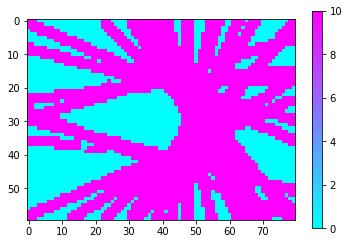

In [31]:
radiation_area = np.zeros(beam_set[0].shape)

for i in range(0, num_beams):
    radiation_area = radiation_area + (actual_solution.x[i] * beam_set[i])

radiation_area[radiation_area<9.9]=0
radiation_area[radiation_area>10]=10
plt.imshow(radiation_area, cmap='cool')
plt.colorbar()

Indeed, while our radiation beams did not all manage to satisfy the minimum tumor radiation constraints, we see that the program did successfully avoid using beams which cross over the critical region. While this formulation may be infeasible, it appears we are on the right track. In order to get a feasible result, let us now relax our constraints to allow for some wiggle room:

## Task 2.2

We will now implement our relaxed threshold model. Let us create these in the straightforward manner as with the small example.

In [32]:
delta_tumor_dose = 3
delta_critical_dose = 3

delta_tumor_dose_vector = delta_tumor_dose * tumor_flat
delta_critical_dose_vector = delta_critical_dose * critical_flat

def relaxed_tumor_radiation_constraint(x):
    normal_bound = tumor_radiation_constraint(x)
    result = normal_bound - delta_tumor_dose_vector
    return result

def relaxed_critical_radiation_constraint(x):
    normal_bound = critical_radiation_constraint(x)
    result = normal_bound + delta_critical_dose_vector
    return result

For implementation purposes, we will add a maximum weight constraint as well. This is to ensure that the algorithm terminates once minimize() decides to violate the inequality constraints.

And now, redefining our constraints and re-optimizing:

In [33]:
#Weight limit constraint:
WT_LIMIT = 100 #An arbitrary weight limit we would like to impose
#Must return -total+limit
#Since minimize() uses >=0 for its inequalities
def max_radiation_constraint(x):
    total_weight = np.sum(x)
    return -total_weight + WT_LIMIT

In [34]:
#WT_LIMIT is remaining 100, from last time
cons = [{'type':'ineq','fun':relaxed_tumor_radiation_constraint},
        {'type':'ineq','fun':relaxed_critical_radiation_constraint},
        {'type':'ineq','fun':max_radiation_constraint}]

actual_solution = minimize(objective, x0=weights, constraints=cons, bounds=non_negativity_constraint)

And, plotting our radiation pattern:

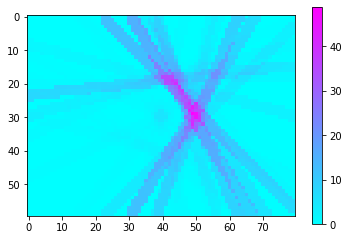

In [35]:
radiation_area = np.zeros(beam_set[0].shape)

for i in range(0, num_beams):
    radiation_area = radiation_area + (actual_solution.x[i] * beam_set[i])

plt.imshow(radiation_area, cmap='cool')
plt.colorbar()

We see that we have achieved a similar result to the previous iteration of our problem, this time yielding a slightly lower total tumor radiation received, reflecting the decreased constraint boundary. Similarly, there is a minor increase in critical area radiation compared to our previous result.

In both instances, the solution follows the pattern of heavily weighting only a handful of beams, and using small fractional weights for the remaining beams.

## Task 2.3

As in the analysis for the small example, we must create and load a border_raw.txt file to indicate where the border of the critical region is. We must then create an associated cost vector for radiating the border region, in preparation for creating a modified cost function.

In [36]:
border_raw = np.loadtxt(path_actual+"border_raw.txt")
border_flat = border_raw.flatten()
cost_border = dosage_matrix @ border_flat

Now, we can create a modified cost function as follows:
$$Z = c_B + c_C - c_T$$
For some border region $c_B$.

In [37]:
def objective_border(x):
    return (cost_critical + cost_border - cost_tumor) @ x

Now, let us re-optimize and plot:

In [38]:
cons = [{'type':'ineq','fun':tumor_radiation_constraint},
        {'type':'ineq','fun':critical_radiation_constraint},
        {'type':'ineq','fun':max_radiation_constraint}]

actual_solution = minimize(objective_border, x0=weights, constraints=cons, bounds=non_negativity_constraint)

print("Objective Function Value: ",objective(actual_solution.x))
print("Tumor radiation received:",(cost_tumor @ actual_solution.x))
print("Critical radiation received:",(cost_critical @ actual_solution.x))

Objective Function Value:  -5809.026206772727
Tumor radiation received: 5853.405075969319
Critical radiation received: 44.37886919659177


Plotting:

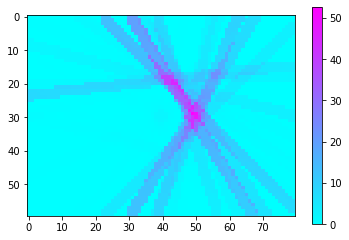

In [39]:
radiation_area = np.zeros(beam_set[0].shape)

for i in range(0, num_beams):
    radiation_area = radiation_area + (actual_solution.x[i] * beam_set[i])

plt.imshow(radiation_area, cmap='cool')
plt.colorbar()

## Task 2.4

Now we must implement our enhanced model. Given what we have observed in our infeasible formulations up to now, it is not clear that a single decision variable for upper and lower bounds on critical and tumor areas (respectively) will yield a feasible result. So, for this problem we will be formulating a version of our enhanced model (as discussed in the paper) which:
* uses a decision variable for the lower bound on each pixel in the tumor region; and
* does not include a decision variable or variables for our critical region, as we appear to be able to avoid it relatively easily.

As our problem is infeasible, we cannot hope to radiate each pixel of the tumor region with the recommended 10 units of radiation. We can, however, create for each pixel a modified radiation threshold of:
$$
b_T - \Delta b_T
$$
and aim to minimize the total $\Delta b_T$ deviations from our recommended dosage $b_T$.

To begin, let us create a decision variable of size [number of tumor pixels + number of beams]:

In [40]:
tumor_set = tumor_flat[tumor_flat!=0]
num_tumor_pixels = len(tumor_set)

critical_set = critical_flat[critical_flat!=0]
num_critical_pixels = len(critical_set)

In [41]:
w_hat = np.zeros(num_tumor_pixels+num_beams)
w_hat

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

For implementation, we will say that the first length(tumor_set) (our number of tumor pixels, 564) of our $\hat{w}$ are our decision variables for the tumor constraint boundaries, and the following 126 onward will be the decision variables for the weights of our 126 beams.

We must now make modified constraints which incorporate these new decision variables. To do this, we must in essence create

In [42]:
tumor_V = tumor_raw.reshape(-1)
critical_V = critical_raw.reshape(-1)

beam_tumor_V = dosage_matrix[:,tumor_V != 0 ]
beam_critical_V = dosage_matrix[:,critical_V != 0]

A_critical_1 = np.zeros((num_critical_pixels, num_tumor_pixels))
A_critical_2 = beam_critical_V.T
A_critical = np.concatenate((A_critical_1,A_critical_2),axis=1)
b_critical = np.ones(num_critical_pixels) * max_critical_dose

# now the tumor constraints
# this allows for each tumor location to have an under-dosage amount
# and these under dosage amounts will be minimized in sum

A_tumor_1 = - np.eye(num_tumor_pixels)
A_tumor_2 = - beam_tumor_V.T
A_tumor = np.concatenate((A_tumor_1,A_tumor_2),axis=1)
b_tumor = - np.ones(num_tumor_pixels) * min_tumor_dose

And now we create an objective function. We know that in practice, if we aim to maximize total radiation provided to all tumor pixels, we will simply select some subset of beams which only radiate the tumor region and assign them weights as high as possible. So, for implementation now, we will simply seek to maximize (or, minimize the negative) of our minimum tumor radiation boundaries.

In [43]:
# now using optimize.minimize()
# using the same matrices as defined above

def objective(x):
    c_1 = np.ones(num_tumor_pixels)
    c_2 = np.zeros(num_beams)
    c = np.concatenate((c_1, c_2))
    return c @ x

def tumor_radiation_constraint(x):
    return - (A_tumor @ x) + b_tumor

def critical_radiation_constraint(x):
    return - (A_critical @ x) + b_critical

non_neg_bounds = (0.0, 1e99)
non_negativity_constraint = []
for i in range(num_tumor_pixels + num_beams ):
    non_negativity_constraint.append(non_neg_bounds)

cons = [{'type':'ineq','fun':tumor_radiation_constraint},
        {'type':'ineq','fun':critical_radiation_constraint}]

actual_solution = opt.minimize(objective, x0=w_hat, constraints=cons, bounds=non_negativity_constraint)

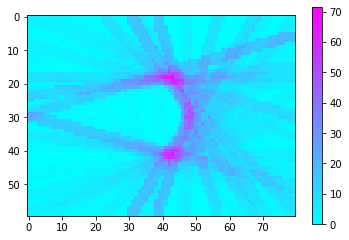

In [44]:
radiation_area = np.zeros(beam_set[0].shape)

for i in range(0, num_beams):
    radiation_area = radiation_area + (actual_solution.x[i+num_tumor_pixels] * beam_set[i])

plt.imshow(radiation_area, cmap='cool')
plt.colorbar()

Let us get a better visual on how well we radiated our tumor region, and how effectively we avoided radiating our critical region.

First, our tumor region:

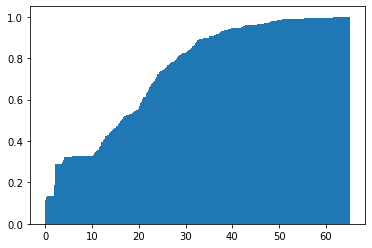

In [49]:
solution_weights = actual_solution.x[num_tumor_pixels:num_tumor_pixels+num_beams]
solution_dosage = dosage_matrix.T @ solution_weights


tumor_N = np.where(tumor_V != 0.)[0].reshape(-1)
tumor_dosages = solution_dosage[tumor_N]
plt.hist(tumor_dosages, bins=1000, cumulative=True, density=True)
plt.show()

Next, our critical region:

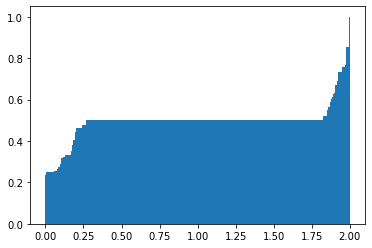

In [50]:
critical_N = np.where(critical_V != 0.)[0].reshape(-1)

critical_dosages = solution_dosage[critical_N]
plt.hist(critical_dosages, bins=1000, cumulative=True, density=True)
plt.show()

Here, we see that by minimizing the total deviations from the lower limit on tumor radiation per pixel, we achieve a result in which roughly 35% of all tumor pixels receive less than the previously-requested dose of 10, while we were able to achieve a result of 10 or greater in the remaining 65% of all pixels. Furthermore, we are successfully able to avoid radiating any portion of the critical area beyond the required 2 dose limit.